In [5]:
%matplotlib inline
#config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

# Point out where your modified camb is
camb_path = "/data2/EUCLID/TSWG-meeting/CAMB-TSWG-meeting/"
sys.path.insert(0, camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

# Matplotlib params set-up

#%matplotlib inline
plt.rc('xtick',labelsize=21)
plt.rc('ytick',labelsize=21)
plt.rc('font',size=35)
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)


Using CAMB 1.3.4 installed at /data2/EUCLID/TSWG-meeting/CAMB-TSWG-meeting/camb


## CAMB modified with a feature in the primordial power spectrum

These cells show that the imported CAMB has a feature in the primordial power spectrum with 5 extra parameters that are part of the InitPower class of CAMB.

In [6]:
# COSMO PARAMETERS
As = 2.12605e-9
ns = 0.96
H0 = 67
ombh2 = 0.022445
omch2 = 0.1205579307
tau = 0.0925
# FEATURE PARAMETERS
amp = 0.0599
freq = 280
wid = 0.08
centre = 0.2
phase = 0.0
# Arrays
ks = np.linspace(0.02,1,1000)

In [7]:
#Primordial power spectrum

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau)
lmax=2500
pars.set_for_lmax(lmax,lens_potential_accuracy=1)
pars.InitPower.set_params(As=As, ns=ns, amp = amp, freq = freq, wid = wid, centre = centre, phase = phase)
feature_pk = pars.scalar_power(ks)
pk_prim = As*(ks/0.05)**(ns-1)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=2.0)

#Linear matter power spectrum
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
#calculate results for these parameters
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')


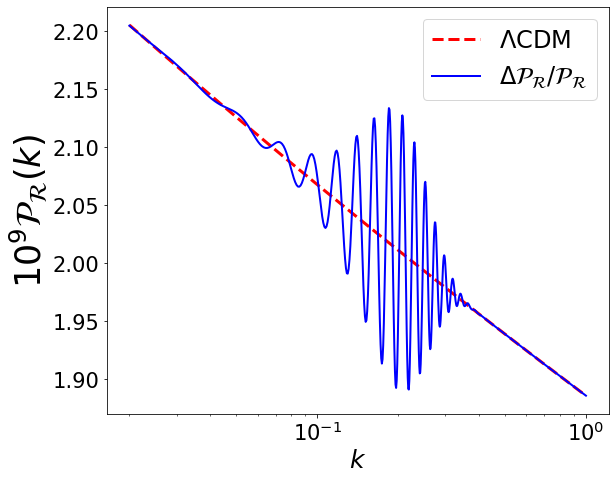

In [8]:
# Plot the feature and featureless primordial power spectra
plt.figure(figsize=(9, 7.5))
plt.semilogx(ks,pk_prim*10**9, 'r--', label=r'$\Lambda$CDM', linewidth=3.0)
plt.semilogx(ks,10**9*feature_pk, 'b-', linewidth=2.0, label=r'$\Delta \mathcal{P}_\mathcal{R}/\mathcal{P}_\mathcal{R}$')
plt.ylabel(r'$10^9\mathcal{P}_\mathcal{R}(k)$', fontsize=35)
plt.xlabel(r'$k$')
plt.legend(loc=1, fontsize=24);

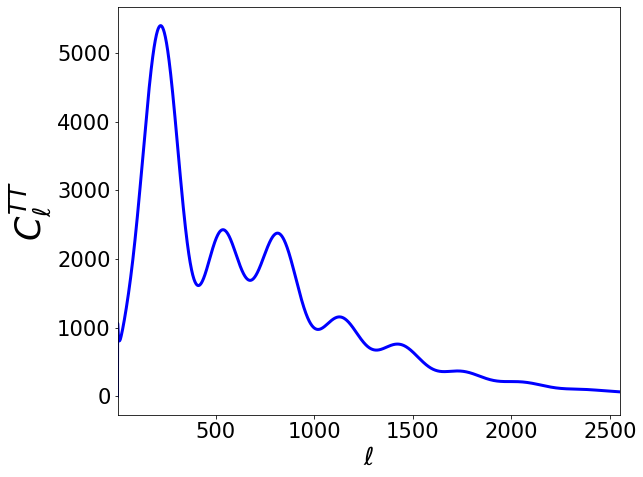

In [9]:
# Plot the corresponding CMB TT angular power spectrum
totCL=powers['total']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
plt.figure(figsize=(9, 7.5))
plt.plot(ls,totCL[:,0], color='b', linewidth=3.0)
plt.ylabel(r'$C_\ell^{TT}$', fontsize=35)
plt.xlabel(r'$\ell$')
#plt.legend();
plt.xlim(2, ls[-1]);

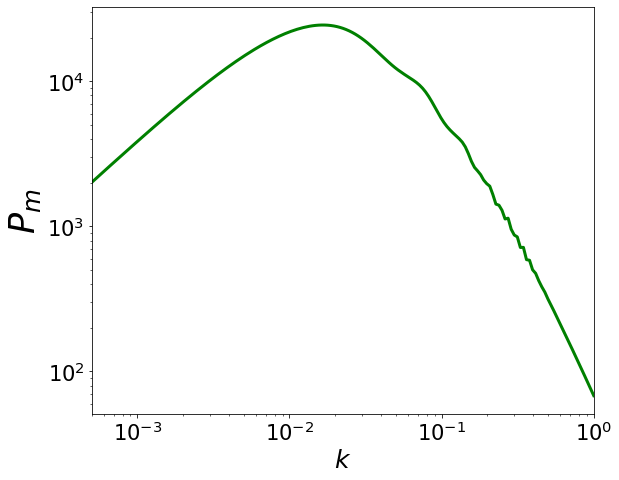

In [10]:
plt.figure(figsize=(9, 7.5))
plt.loglog(kh, pk[0, :], color='g', linewidth=3.0)
plt.ylabel(r'$P_m$', fontsize=35)
plt.xlabel(r'$k$')
#plt.legend();
plt.xlim(5*10**-4, 1);

In [11]:
# The extra parameters I have included are seen in the python interface of CAMB, within the InitPower class
print(pars.InitPower)

class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.96
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2.12605e-09
 At = 1.0
 amp = 0.0599
 freq = 280.0
 wid = 0.08
 centre = 0.2
 phase = 0.0
 


## RUN Cobaya with a modified CAMB

We repeat the same producedure we learnt in the tutorial2 to make an evalution of the posterior using the model wrapper of Cobaya with the modified CAMB. Cobaya requires a config file to run (that can be either a python dictionary, as below, or a `yaml` file). In this file we specify that we want to use CAMB and, in particular, our modified version of CAMB, and we define the new parameters of the modified CAMB in the `params` block.

In [12]:
info = {
    #'params': Cobaya's protected key of the input dictionary. 
    # Includes the parameters that the user would like to sample over:
'params': {
        #
        # For more information see: https://cobaya.readthedocs.io/en/latest/example.html
        'ombh2': ombh2, #Omega density of baryons times the reduced Hubble parameter squared
        'omch2': omch2, #Omega density of cold dark matter times the reduced Hubble parameter squared
        'H0': H0, #Hubble parameter evaluated today (z=0) in km/s/Mpc
        'tau': tau, #optical depth
        'mnu': 0.06, #  sum of the mass of neutrinos in eV
        'nnu': 3.046, #N_eff of relativistic species 
        'As': As, #Amplitude of the primordial scalar power spectrum
        'ns': ns, # primordial power spectrum tilt (sampled with an uniform prior)
        'w': -1, #Dark energy fluid model
        'wa': 0, #Dark energy fluid model
        'omk': 0.0, #curvature density
        'omegam': None, #DERIVED parameter: Omega matter density
        'omegab': None, #DERIVED parameter: Omega baryon density
        'omeganu': None, #DERIVED parameter: Omega neutrino density
        'omnuh2': None, #DERIVED parameter: Omega neutrino density times de reduced Hubble parameter squared
        'omegac': None, #DERIVED parameter: Omega cold dark matter density
        'N_eff': None, 
        # FEATURES PARAMETERS
        # INCLUDE HERE THE NEW PARAMETERS OF THE FEATURE AS DEFINED in the InitPower
        ...
        },
    #'theory': we select CAMB and pass the path to this modified CAMB
    'theory': {'camb': 
               {'path': ...,
                'ignore_obsolete': True, #You can ask Cobaya to ignore this is an old version
                'stop_at_error': True, 
                'extra_args':{'num_massive_neutrinos': 1,
                              'dark_energy_model': 'ppf'}}},
    #'sampler': evaluation
    'sampler': {'evaluate': None},  
    }

In [13]:
# Import the likelihood and invoke Cobaya
info['likelihood'] = {'planck_2018_highl_plik.TTTEEE': None}

In [14]:
# Import model wrapper of Cobaya and create an instance of the `model` wrapper called model
from cobaya.model import get_model

# Second: create an instance of the `model` wrapper called model
model = ...

[model] *WARNING* Ignored blocks/options: ['sampler']
[prior] *WARNING* External prior 'SZ' loaded. Mind that it might not be normalized!
[camb] `camb` module loaded successfully from /data2/EUCLID/TSWG-meeting/CAMB-TSWG-meeting/camb
[planck_2018_highl_plik.ttteee] `clik` module loaded successfully from /data2/cobaya_modules/cobaya_modules/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik


In [15]:
# Make a computation of the logposterior on that point
...

{'ombh2': 0.022445, 'omch2': 0.1205579307, 'H0': 67.0, 'tau': 0.0925, 'mnu': 0.06, 'nnu': 3.046, 'As': 2.12605e-09, 'ns': 0.96, 'w': -1.0, 'wa': 0.0, 'omk': 0.0, 'amp': 0.0599, 'freq': 280.0, 'wid': 0.08, 'centre': 0.2, 'phase': 0.0, 'A_planck': 0.9984869166408257, 'calib_100T': 1.0006817361414015, 'calib_217T': 0.9983089830342935, 'A_pol': 1.0, 'calib_100P': 1.021, 'calib_143P': 0.966, 'calib_217P': 1.04, 'cib_index': -1.3, 'A_cib_217': 169.9520438922792, 'xi_sz_cib': 0.5888822760295578, 'A_sz': 7.082897068248516, 'ksz_norm': 1.7412059856883577, 'gal545_A_100': 6.563049646708363, 'gal545_A_143': 15.087638356725556, 'gal545_A_143_217': 20.04544124993267, 'gal545_A_217': 142.82265616207144, 'A_sbpx_100_100_TT': 1.0, 'A_sbpx_143_143_TT': 1.0, 'A_sbpx_143_217_TT': 1.0, 'A_sbpx_217_217_TT': 1.0, 'ps_A_100_100': 195.58101837792864, 'ps_A_143_143': 260.6311333724293, 'ps_A_143_217': 388.77720618553195, 'ps_A_217_217': 394.1346253828424, 'galf_TE_index': -2.4, 'galf_TE_A_100': 0.0594812288855

## Plot CMB observables

Let's extract the CMB angular power spectrum as in the tutorial2

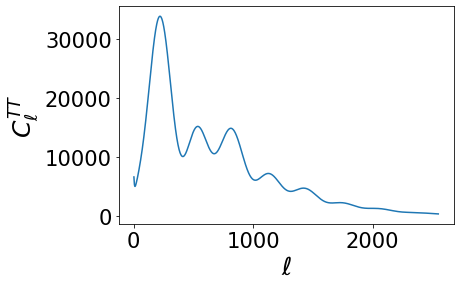

In [16]:
# Follow what you did in tutorial2

Cls = ...

[model] *WARNING* Ignored blocks/options: ['sampler']
[prior] *WARNING* External prior 'SZ' loaded. Mind that it might not be normalized!
[camb] `camb` module loaded successfully from /data2/EUCLID/TSWG-meeting/CAMB-TSWG-meeting/camb
[planck_2018_highl_plik.ttteee] `clik` module loaded successfully from /data2/cobaya_modules/cobaya_modules/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik


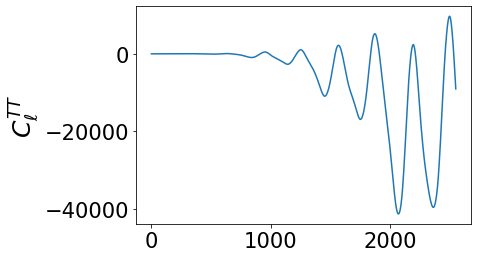

In [22]:
# Now plot the difference with respect LCDM (featureless primordial power spectrum)
# For that, we re-run a new model instance for the LCDM case in which all features
# parameters are zero

info_LCDM = info.copy()
info_LCDM['params']['amp'] = 0
info_LCDM['params']['freq'] = 0
info_LCDM['params']['wid'] = 0
info_LCDM['params']['centre'] = 0
info_LCDM['params']['phase'] = 0


# Let's plot the difference in the angular power spectra

...